# dramsim3-sweep
9/26/2023

Sweep ChampSim with DRAMsim3 and vanilla model at different bandwidths

In [2]:
import json
import os
from typing import Dict, List, Optional

import matplotlib.pyplot as plt
import numpy as np

# Configuration

In [3]:
sim_dir = "/u/cmolder/GitHub/ChampSim/sim/"
sim_study = "baseline"
sim_experiment = "_baseline"
bandwidths = [200, 266, 333, 400, 533, 666, 800, 1066, 1333, 1600,
              1866, 2133, 2400, 2666, 2933, 3200]
traces = {
    "GemsFDTD": "GemsFDTD_109B",
    #"lbm": "lbm_94B",
    #"leslie3d": "leslie3d_1116B",
    "libquantum": "libquantum_1210B",
    "mcf": "mcf_46B",
    "soplex": "soplex_66B",
}

dpi = 150

In [4]:
def load_stats(base_dir: str, trace: str) -> Dict:
    champsim_stats_path = os.path.join(base_dir, f"{trace}.json")
    dramsim3_stats_path = os.path.join(base_dir, f"{trace}.dramsim3.json")

    data = {}
    with open(champsim_stats_path) as f:
        data["champsim"] = json.load(f)
    if os.path.exists(dramsim3_stats_path):
        with open(dramsim3_stats_path) as f:
            data["dramsim3"] = json.load(f)
    else:
        data["dramsim3"] = None
    return data

In [5]:
csim_data = {}
ds3_data = {}

for bw in bandwidths:
    for bmark, tr in traces.items():
        csim_base_dir = os.path.join(sim_dir, "dram_champsim", f"default_{bw}", sim_study, sim_experiment, bmark)
        ds3_base_dir = os.path.join(sim_dir, "dram_dramsim3", f"default_{bw}", sim_study, sim_experiment, bmark)
        
        csim_data[(bw, tr)] = load_stats(csim_base_dir, tr)
        ds3_data[(bw, tr)] = load_stats(ds3_base_dir, tr)

# Bandwidth studies

In [19]:
def cycles_to_ns(cycles, freqs):
    return cycles * (1000 / freqs)

def mtps_to_gibps(x):
    return x * 8 * 0.000931322574615478515625

def gibps_to_mtps(x):
    return x / 8 / 0.000931322574615478515625

def plot_dram_sweep_multiplot(csim_data, ds3_data, traces: List[str],
                              metric: str = "avg read latency", 
                              ymin: Optional[float] = None,
                              ymax: Optional[float] = None):
    
    CSIM_METRIC_FNS = {
        "avg read latency": lambda dat: dat["champsim"][0]["roi"]["DRAM"][0]["avg read latency"],
        "avg interarrival latency": lambda dat: dat["champsim"][0]["roi"]["DRAM"][0]["avg interarrival latency"],
        "read row hit rate": lambda dat: (
            dat["champsim"][0]["roi"]["DRAM"][0]["RQ ROW_BUFFER_HIT"] /
            (dat["champsim"][0]["roi"]["DRAM"][0]["RQ ROW_BUFFER_HIT"] 
             + dat["champsim"][0]["roi"]["DRAM"][0]["RQ ROW_BUFFER_MISS"])
        ),
        "avg llc miss latency": lambda data: data["champsim"][0]["roi"]["LLC"]["total miss latency avg"],
        "avg llc read miss latency": lambda data: data["champsim"][0]["roi"]["LLC"]["LOAD"]["miss latency avg"],
        "num reads": lambda dat: (
            dat["champsim"][0]["roi"]["DRAM"][0]["RQ ROW_BUFFER_HIT"] 
            + dat["champsim"][0]["roi"]["DRAM"][0]["RQ ROW_BUFFER_MISS"]
        ),
        "num writes": lambda dat: (
            dat["champsim"][0]["roi"]["DRAM"][0]["WQ ROW_BUFFER_HIT"] 
            + dat["champsim"][0]["roi"]["DRAM"][0]["WQ ROW_BUFFER_MISS"]
        ),
        "ipc": lambda data: (
            data["champsim"][0]["roi"]["cores"][0]["instructions"]
            / data["champsim"][0]["roi"]["cores"][0]["cycles"]
        )
    }
    DS3_METRIC_FNS = {
        "avg read latency": lambda dat: dat["dramsim3"]["0"]["average_read_latency"],
        "avg interarrival latency": lambda dat: dat["dramsim3"]["0"]["average_interarrival"],
        "read row hit rate": lambda dat: (
            dat["dramsim3"]["0"]["num_read_row_hits"] 
            / dat["dramsim3"]["0"]["num_reads_done"]
        ),
        "avg llc miss latency": lambda data: data["champsim"][0]["roi"]["LLC"]["total miss latency avg"],
        "avg llc read miss latency": lambda data: data["champsim"][0]["roi"]["LLC"]["LOAD"]["miss latency avg"],
        "num reads": lambda dat: dat["dramsim3"]["0"]["num_reads_done"],
        "num writes": lambda dat: dat["dramsim3"]["0"]["num_writes_done"],
        "ipc": lambda data: (
            data["champsim"][0]["roi"]["cores"][0]["instructions"]
            / data["champsim"][0]["roi"]["cores"][0]["cycles"]
        )
    }
    
    fig, axs = plt.subplots(2, 2, figsize=(7, 5), dpi=dpi)
    axs = axs.flatten()
    secaxs = []

    for i, trace in enumerate(traces):
        csim_data_tr = {bw: CSIM_METRIC_FNS[metric](dat) for (bw, tr), dat in csim_data.items() if tr == trace}
        ds3_data_tr = {bw: DS3_METRIC_FNS[metric](dat) for (bw, tr), dat in ds3_data.items() if tr == trace}

        X_csim, X_ds3 = np.array(list(csim_data_tr.keys()), dtype=np.float32), np.array(list(ds3_data_tr.keys()), dtype=np.float32)
        y_csim, y_ds3 = np.array(list(csim_data_tr.values()), dtype=np.float32), np.array(list(ds3_data_tr.values()), dtype=np.float32)

        metric_ = metric
        if (metric == "avg read latency" 
            or metric == "avg interarrival latency"
            or metric == "avg write latency"):
            y_csim = cycles_to_ns(y_csim, X_csim)
            y_ds3 = cycles_to_ns(y_ds3, X_ds3 / 2)
            metric_ += " (ns)"
        elif (metric == "avg llc miss latency"
              or metric == "avg llc read miss latency"):
            y_csim = cycles_to_ns(y_csim, 4000)
            y_ds3 = cycles_to_ns(y_ds3, 4000)
            metric_ += " (ns)"

        axs[i].plot(X_csim, y_csim,
                    label="ChampSim" if i == 0 else None, 
                    marker='o', markersize=3, 
                    color='C0')
        axs[i].plot(X_ds3, y_ds3, 
                    label="DRAMsim3" if i == 0 else None, 
                    marker='o', markersize=3,
                    color='C2')

        axs[i].grid(axis='both', color='lightgray')
        axs[i].set_title(trace, weight='bold')
        axs[i].set_ylim(ymin=ymin, ymax=ymax)
        axs[i].set_xlim(xmin=0)
        secaxs.append(axs[i].secondary_xaxis('top', functions=(mtps_to_gibps, gibps_to_mtps)))

        axs[i].xaxis.set_tick_params(labelsize=7.5)
        axs[i].yaxis.set_tick_params(labelsize=7.5)
        secaxs[i].xaxis.set_tick_params(labelsize=7.5)

        axs[i].set_xlabel("DRAM data rate (MT/s)", fontsize=7.5)
        secaxs[i].set_xlabel('DRAM bandwidth (GiB/s)', fontsize=7.5)
        axs[i].set_ylabel(metric_, fontsize=7.5)


    # axs[2].set_xlabel("DRAM data rate (MT/s)", fontsize=7.5)
    # axs[3].set_xlabel("DRAM data rate (MT/s)", fontsize=7.5)

    # secaxs[0].set_xlabel('DRAM bandwidth (GiB/s)', fontsize=7.5)
    # secaxs[1].set_xlabel('DRAM bandwidth (GiB/s)', fontsize=7.5)

    # axs[0].set_ylabel(metric_, fontsize=7.5)
    # axs[2].set_ylabel(metric_, fontsize=7.5)
    
    fig.legend(loc='center', ncol=3, fontsize=7.5)
    fig.tight_layout()
    plt.savefig(f"plots/{metric}.png", bbox_inches='tight', dpi=dpi)

## Avg. read latency

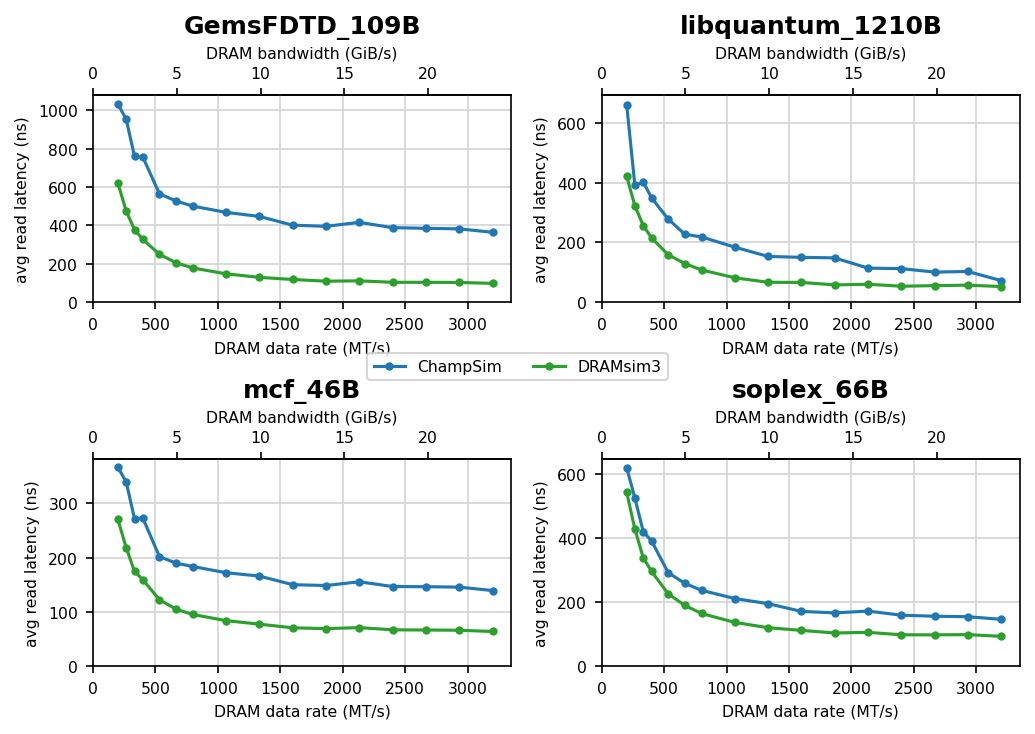

In [7]:
plot_dram_sweep_multiplot(csim_data, ds3_data, list(traces.values()), 
                          metric="avg read latency", ymin=0)

## Avg. interarrival latency

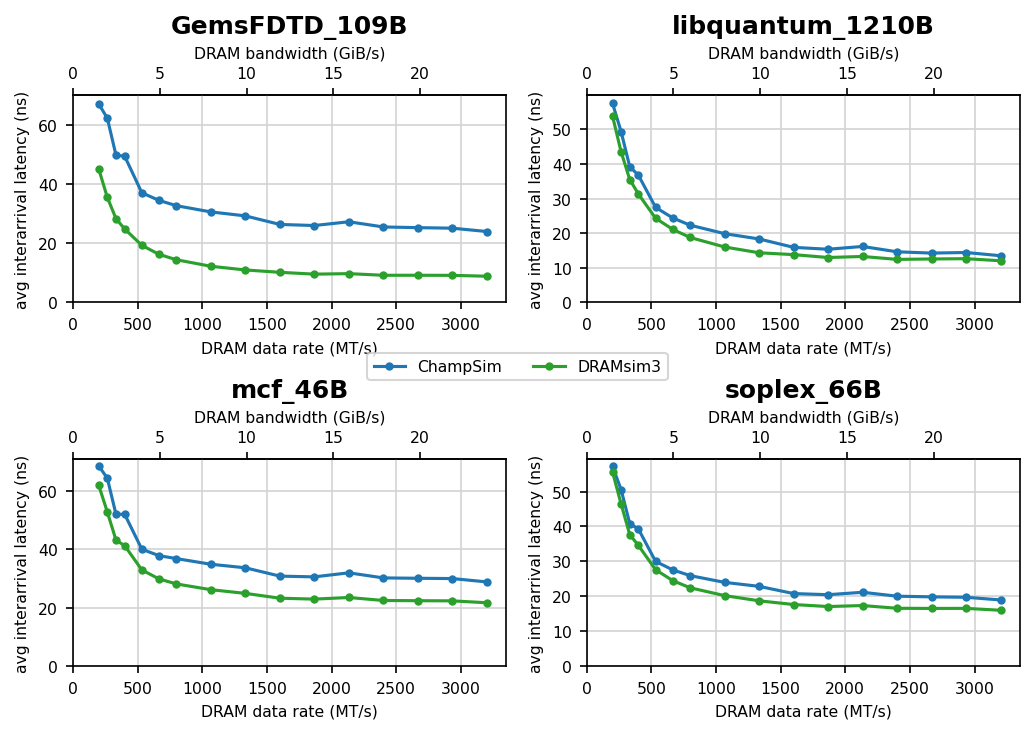

In [8]:
plot_dram_sweep_multiplot(csim_data, ds3_data, list(traces.values()), 
                          metric="avg interarrival latency", ymin=0)

## Read row hit rate

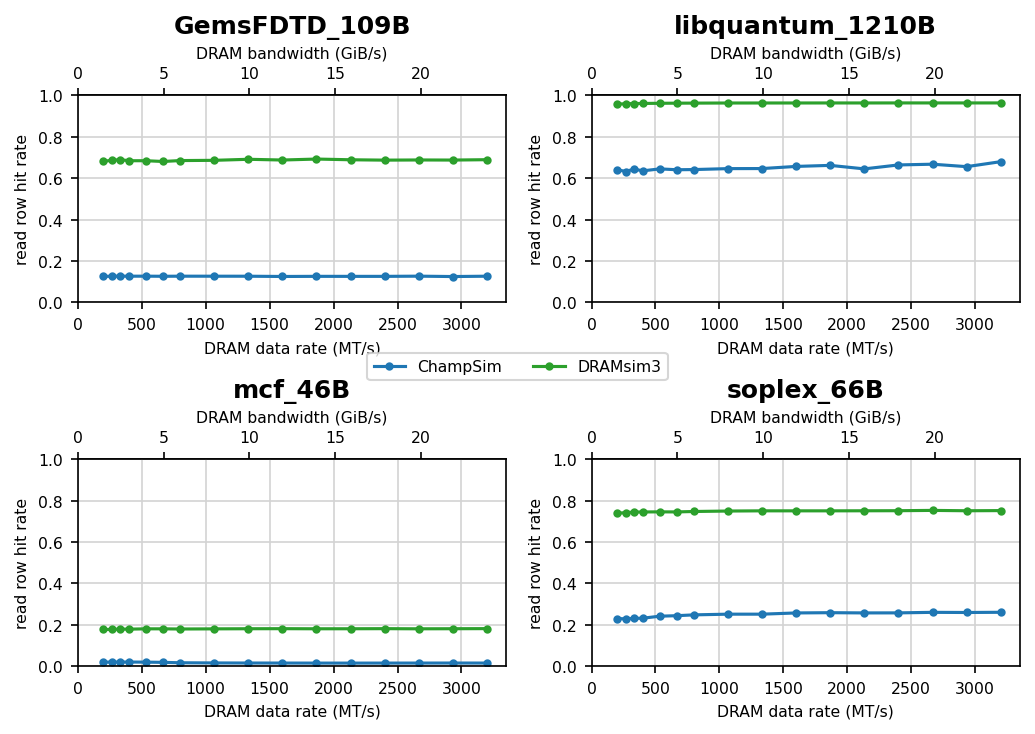

In [9]:
plot_dram_sweep_multiplot(csim_data, ds3_data, list(traces.values()), 
                          metric="read row hit rate", 
                          ymin=0.0, ymax=1.0)

## Avg. LLC miss latency

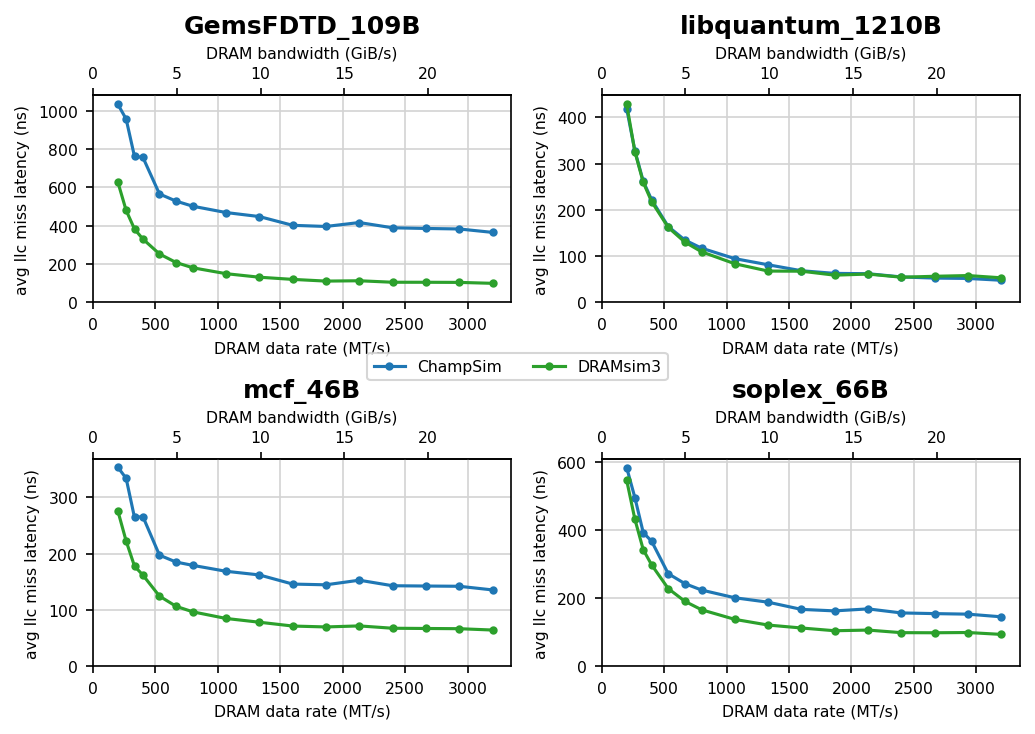

In [10]:
plot_dram_sweep_multiplot(csim_data, ds3_data, list(traces.values()), 
                          metric="avg llc miss latency",
                          ymin=0.0)#, ymax=1000.0)

## Avg. LLC read miss latency

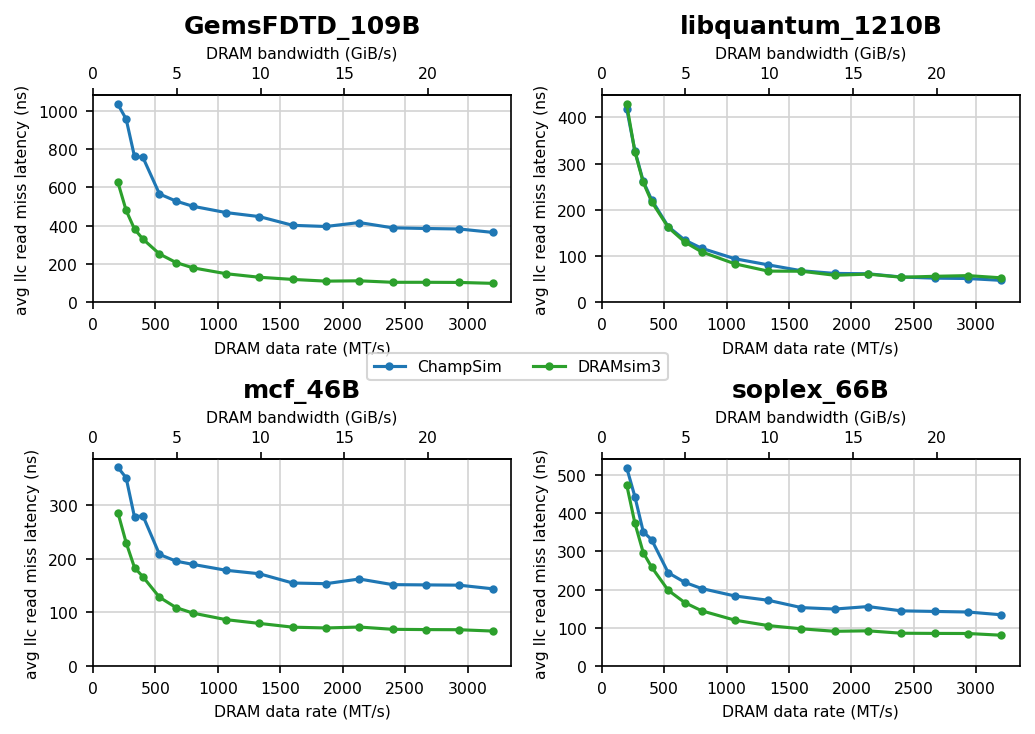

In [21]:
plot_dram_sweep_multiplot(csim_data, ds3_data, list(traces.values()), 
                          metric="avg llc read miss latency",
                          ymin=0.0)#, ymax=1000.0)

## Num reads

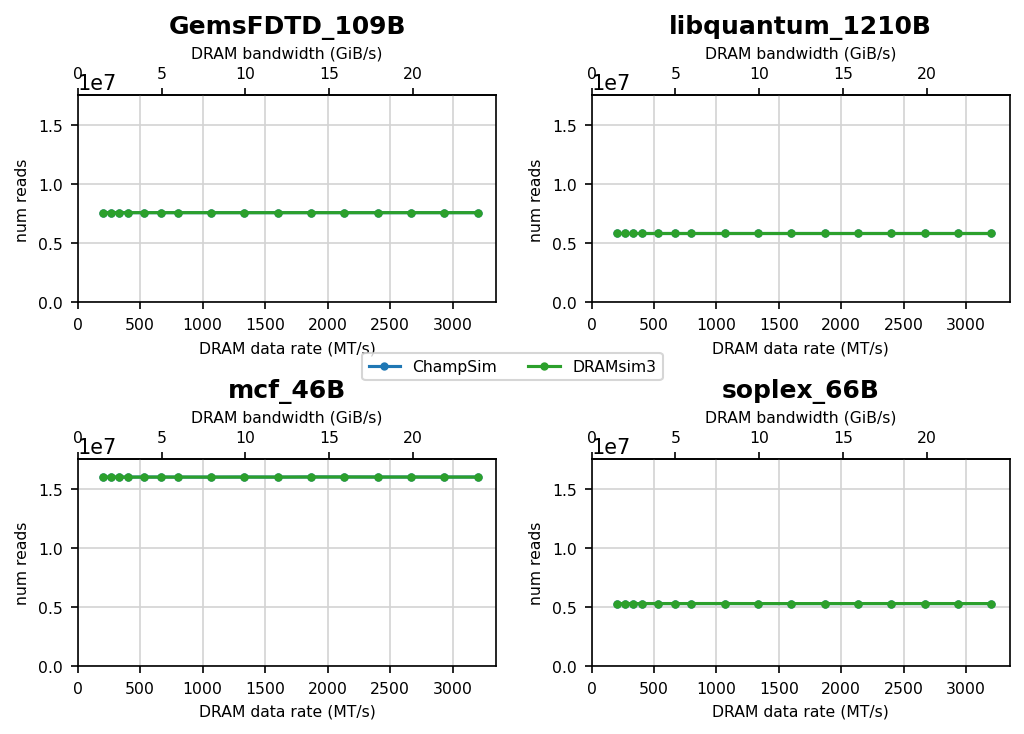

In [11]:
plot_dram_sweep_multiplot(csim_data, ds3_data, list(traces.values()), 
                          metric="num reads",
                          ymin=0.0, ymax=1.75e7)

## Num writes

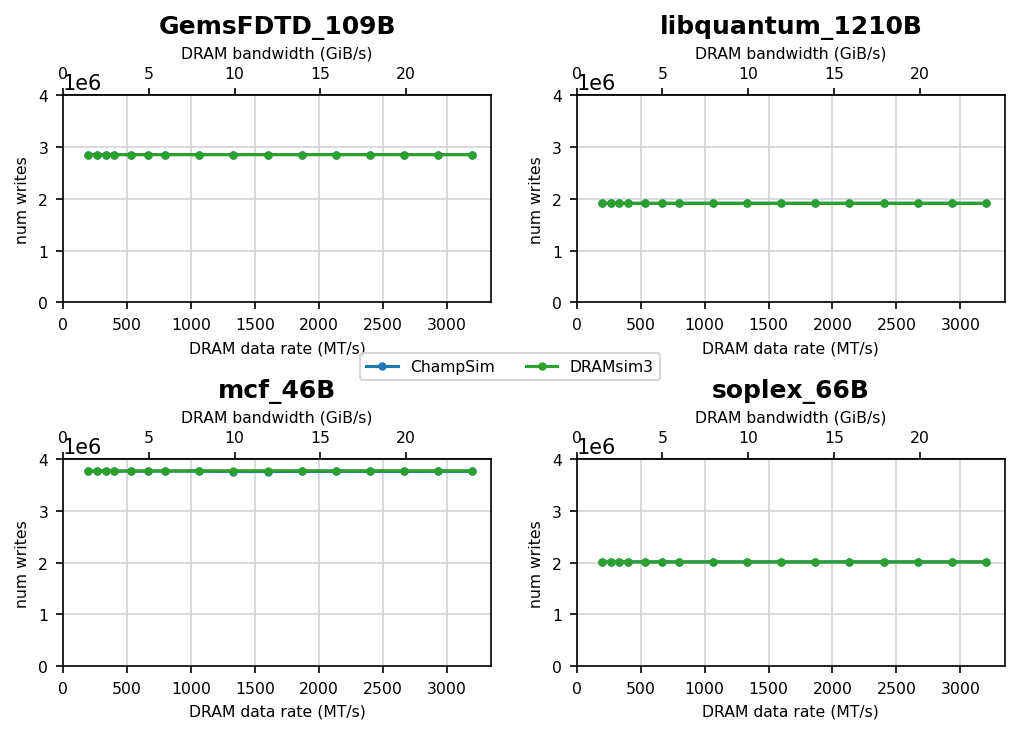

In [12]:
plot_dram_sweep_multiplot(csim_data, ds3_data, list(traces.values()), 
                          metric="num writes",
                          ymin=0.0, ymax = 4e6)

## IPC

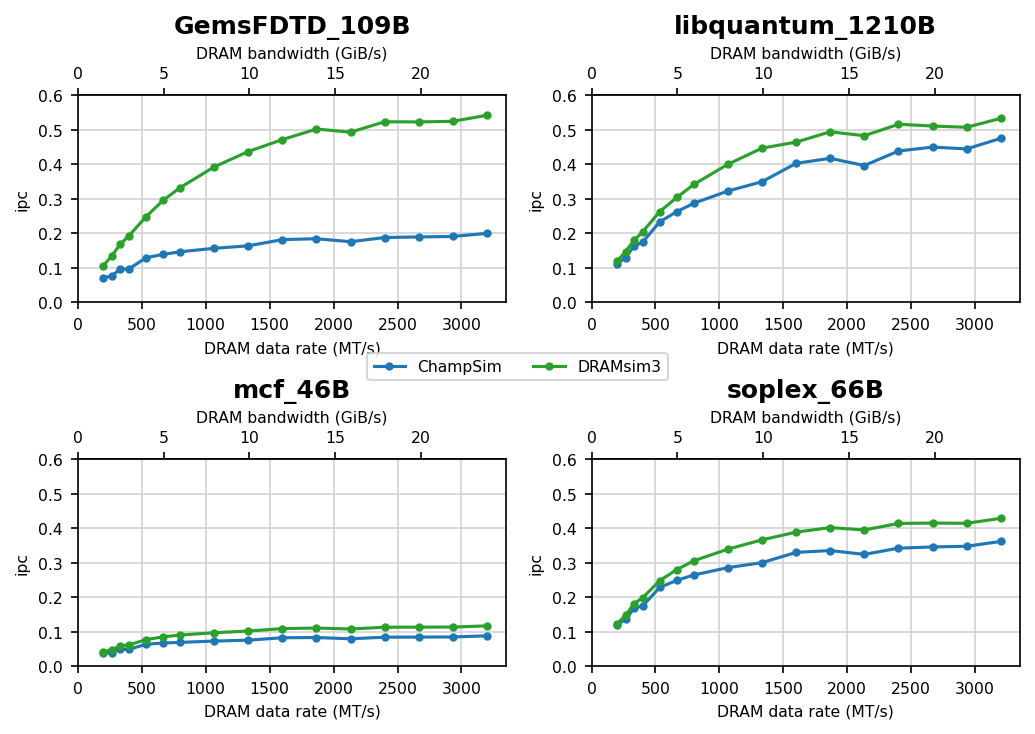

In [13]:
plot_dram_sweep_multiplot(csim_data, ds3_data, list(traces.values()), 
                          metric="ipc",
                          ymin=0.0, ymax=0.6)

# Histograms

In [14]:
def plot_latency_histogram(csim_data: dict, ds3_data: dict, bw: int, trace: str, metric: str = "read latency",
                           min_bin = 0, max_bin = 1000, bins = 100):
    CSIM_METRIC_FNS = {
        "read latency": lambda dat: dat["champsim"][0]["roi"]["DRAM"][0]["read latency histogram"],
        "write latency": lambda dat: dat["champsim"][0]["roi"]["DRAM"][0]["write latency histogram"],
        "interarrival latency": lambda dat: dat["champsim"][0]["roi"]["DRAM"][0]["interarrival latency histogram"],
    }
    DS3_METRIC_FNS = {
        "read latency": lambda dat: dat["dramsim3"]["0"]["read_latency"],
        "write latency": lambda dat: dat["dramsim3"]["0"]["write_latency"],
        "interarrival latency": lambda dat: dat["dramsim3"]["0"]["interarrival_latency"],
    }

    csim_data = CSIM_METRIC_FNS[metric](csim_data[(bw, trace)])
    ds3_data = DS3_METRIC_FNS[metric](ds3_data[(bw, trace)])

    csim_data = dict(sorted({cycles_to_ns(int(k), bw): v for k, v in csim_data.items()}.items()))
    ds3_data = dict(sorted({cycles_to_ns(int(k), bw/2): v for k, v in ds3_data.items()}.items()))
    # csim_data = dict(sorted({int(k): v for k, v in csim_data.items()}.items()))
    # ds3_data = dict(sorted({int(k): v for k, v in ds3_data.items()}.items()))

    fig, axs = plt.subplots(1, 2, figsize=(6, 3), dpi=dpi)
    axs = axs.flatten()
    
    # ChampSim
    axs[0].hist(csim_data.keys(), bins=bins, weights=csim_data.values(), 
                range=(min_bin, max_bin), color = 'C0')
    axs[0].set_title("ChampSim")
    axs[0].set_xlabel(f"{metric} (ns)")
    axs[0].set_xlim(min_bin, max_bin)
    axs[0].set_ylabel("count")
    axs[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    axs[0].grid(axis='y', color='lightgray')
    axs[0].set_axisbelow(True)
    
    # DRAMsim3
    axs[1].hist(ds3_data.keys(), bins=bins, weights=ds3_data.values(), 
                range=(min_bin, max_bin), color = 'C2')
    axs[1].set_title("DRAMsim3")
    axs[1].set_xlabel(f"{metric} (ns)")
    axs[1].set_xlim(min_bin, max_bin)
    axs[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    axs[1].grid(axis='y', color='lightgray')
    axs[1].set_axisbelow(True)

    fig.suptitle(f"{trace} {bw} MT/s {metric}")
    fig.tight_layout()
    plt.savefig(f"plots/{metric} histogram {trace} {bw}_mtps.png", bbox_inches='tight', dpi=dpi)

## Read latency

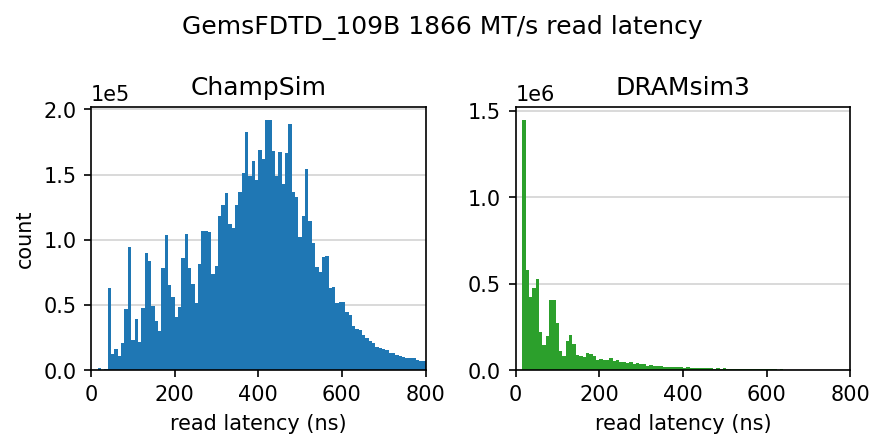

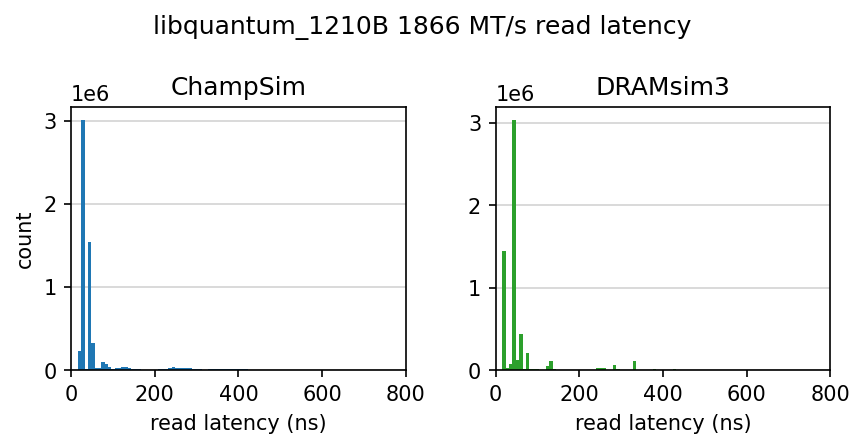

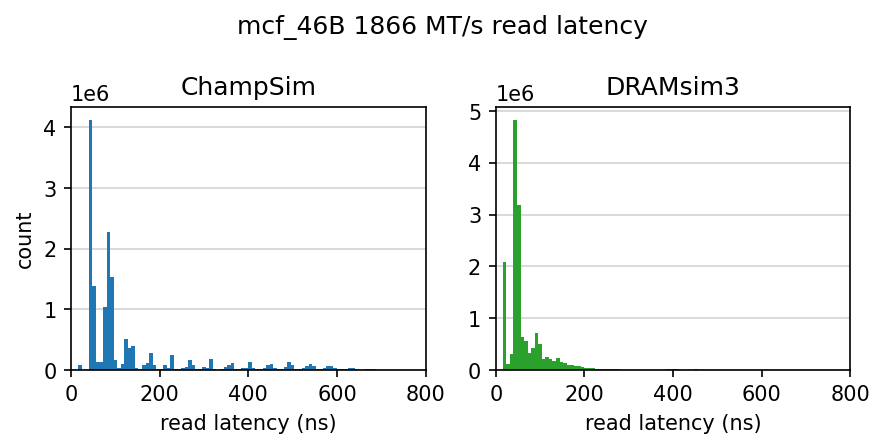

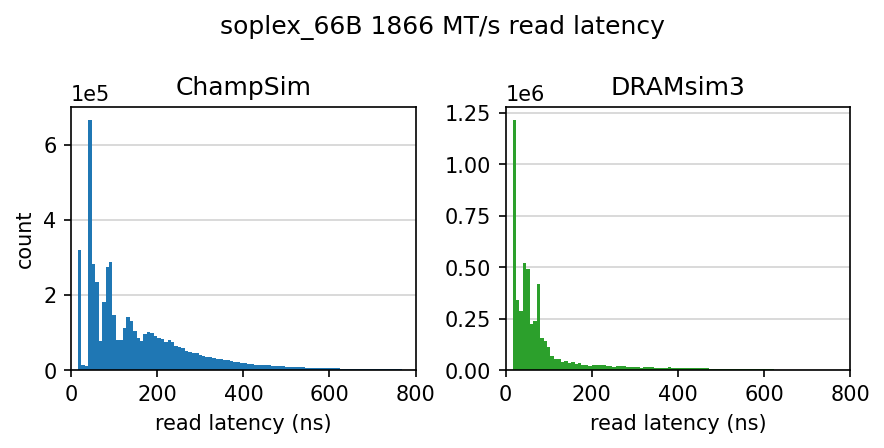

In [15]:
for trace in traces.values():
    plot_latency_histogram(csim_data, ds3_data, 1866, trace, 
                           metric="read latency",
                           max_bin=800)

## Write latency

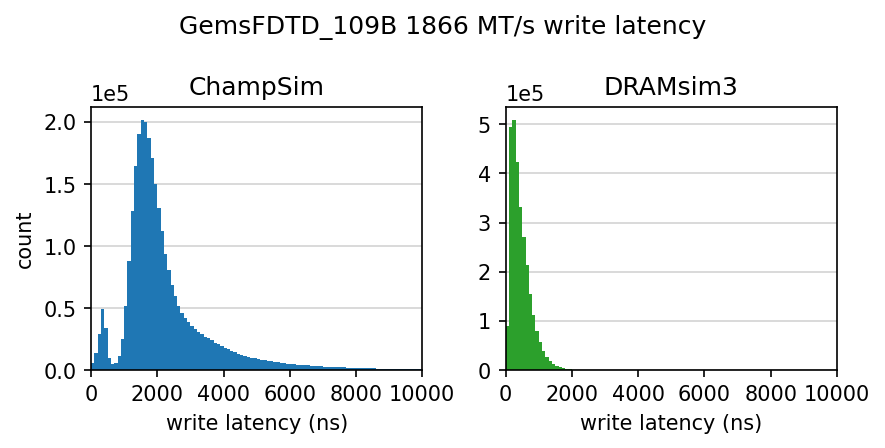

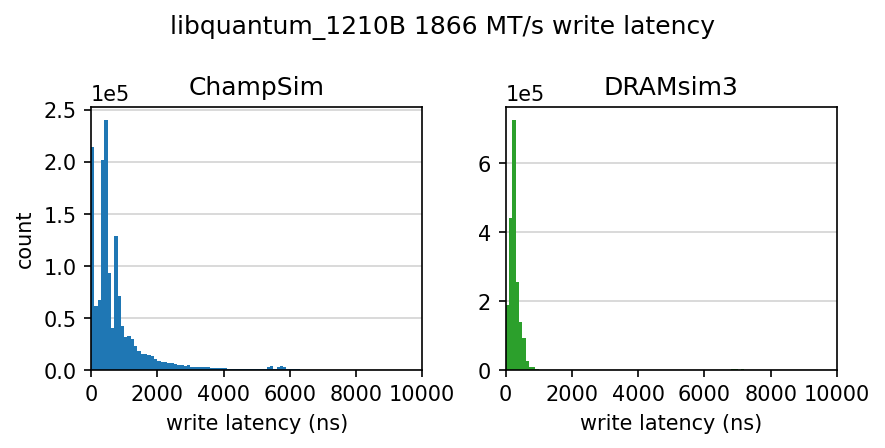

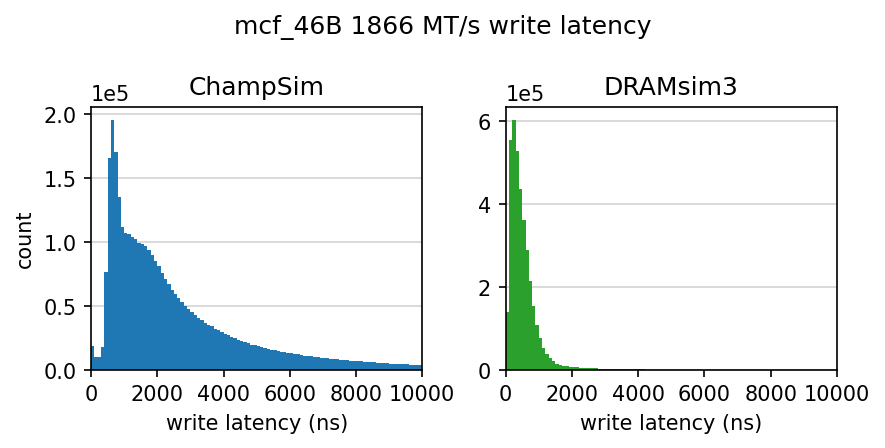

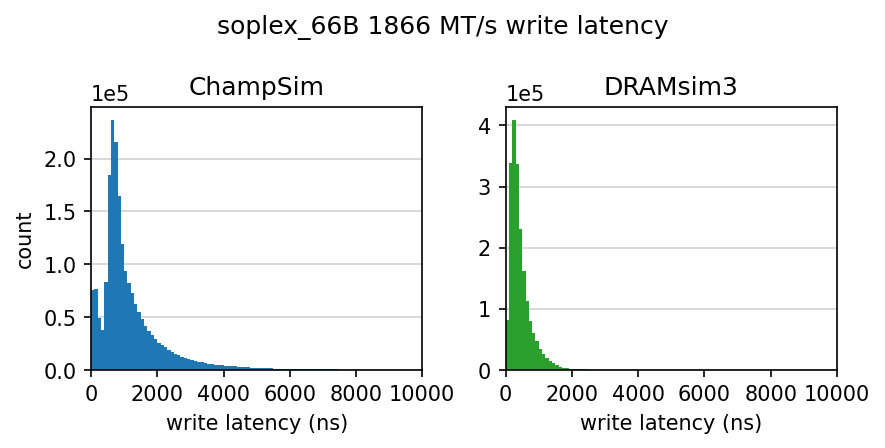

In [16]:
for trace in traces.values():
    plot_latency_histogram(csim_data, ds3_data, 1866, trace, 
                           metric="write latency",
                           max_bin=10000)

## Interarrival latency

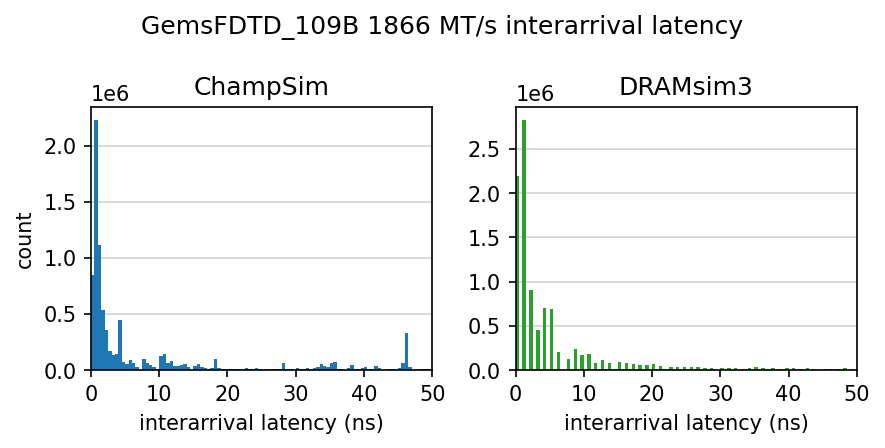

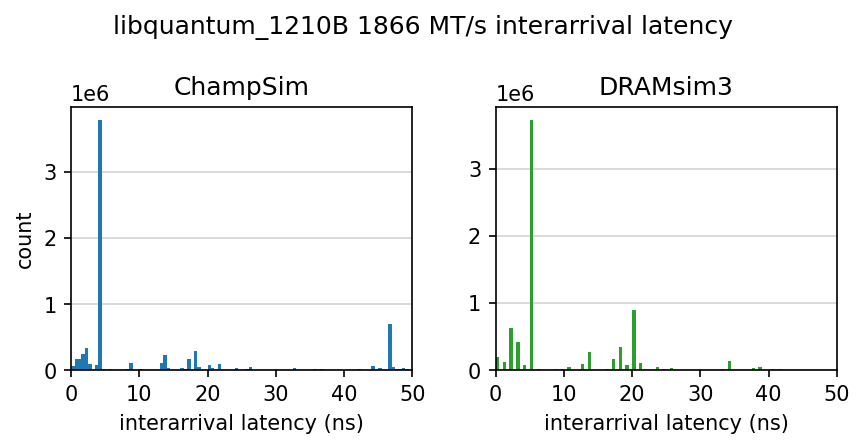

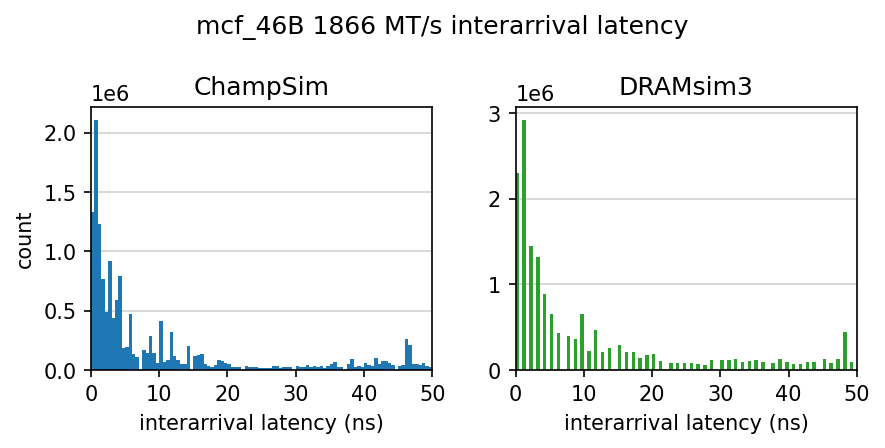

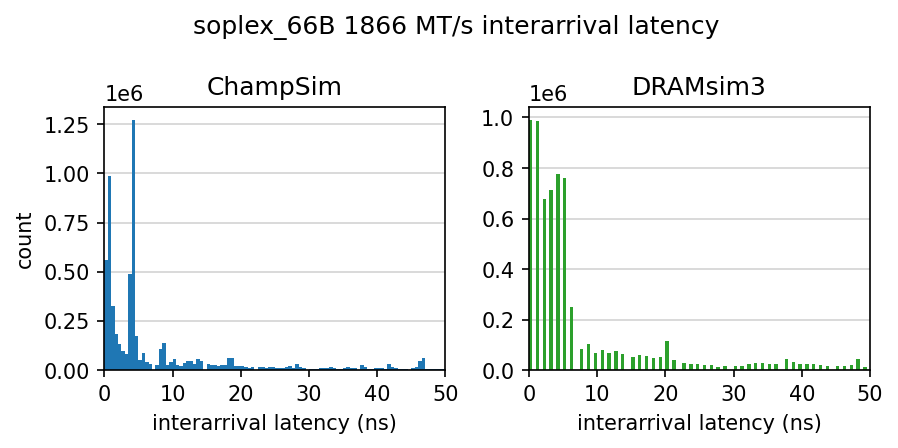

In [17]:
for trace in traces.values():
    plot_latency_histogram(csim_data, ds3_data, 1866, trace, 
                           metric="interarrival latency",
                           max_bin=50)